Create a jupyter notebook template to do the following - for a given token and date range:
1. calculate the hourly return by timestamp
2. calculate the hourly volatility (you can use the formula we went over in class)
3. calculate maximum drawdown up to that hour for each hour
4. then plot in a 2x2 grid:hourly return, hourly vol, maximum drawdown, close prices, color each day on the graph

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter

C:\Users\15103\Conda\envs\lecture_4\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

<Figure size 432x288 with 0 Axes>

In [3]:
%matplotlib inline

In [4]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///data/data.db'

In [5]:
# Parameters
from_date = "2021-11-29"
to_date = "2021-12-13"
token = "BTC"
connection_string = "sqlite:///data/data.db"


In [6]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [7]:
prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,50274.37,50828.13,50274.37,50489.97,1629.235048,8.234571e+07,BTC,BTC
2021-12-12 20:00:00,50481.75,50621.33,50148.04,50240.20,424.455328,2.138626e+07,BTC,BTC
2021-12-12 21:00:00,50245.59,50589.46,50180.32,50305.85,410.233785,2.068859e+07,BTC,BTC


Here I used the same volatility definition as the one in the market analysis template. However, I set the lookback period to be 3.

In [8]:
def vol_ohlc(df, lookback=3):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [9]:
def series_plot(data, ax=None):
    data.plot(ax=ax, legend=False)
    ax.set_title(label=list(data.columns)[0], loc='left')
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [10]:
prices['volatility']=vol_ohlc(prices)

In [11]:
prices['hourly return'] = np.log(prices.close)-np.log(prices.open)

In [12]:
prices['hourly drawdown'] = prices.high-prices.close

In [13]:
prices['maximum drawdown']=0
for i in range(prices.shape[0]):
     prices['maximum drawdown'].iloc[i]=prices['hourly drawdown'].iloc[0:(i+1)].max()

C:\Users\15103\Conda\envs\lecture_4\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

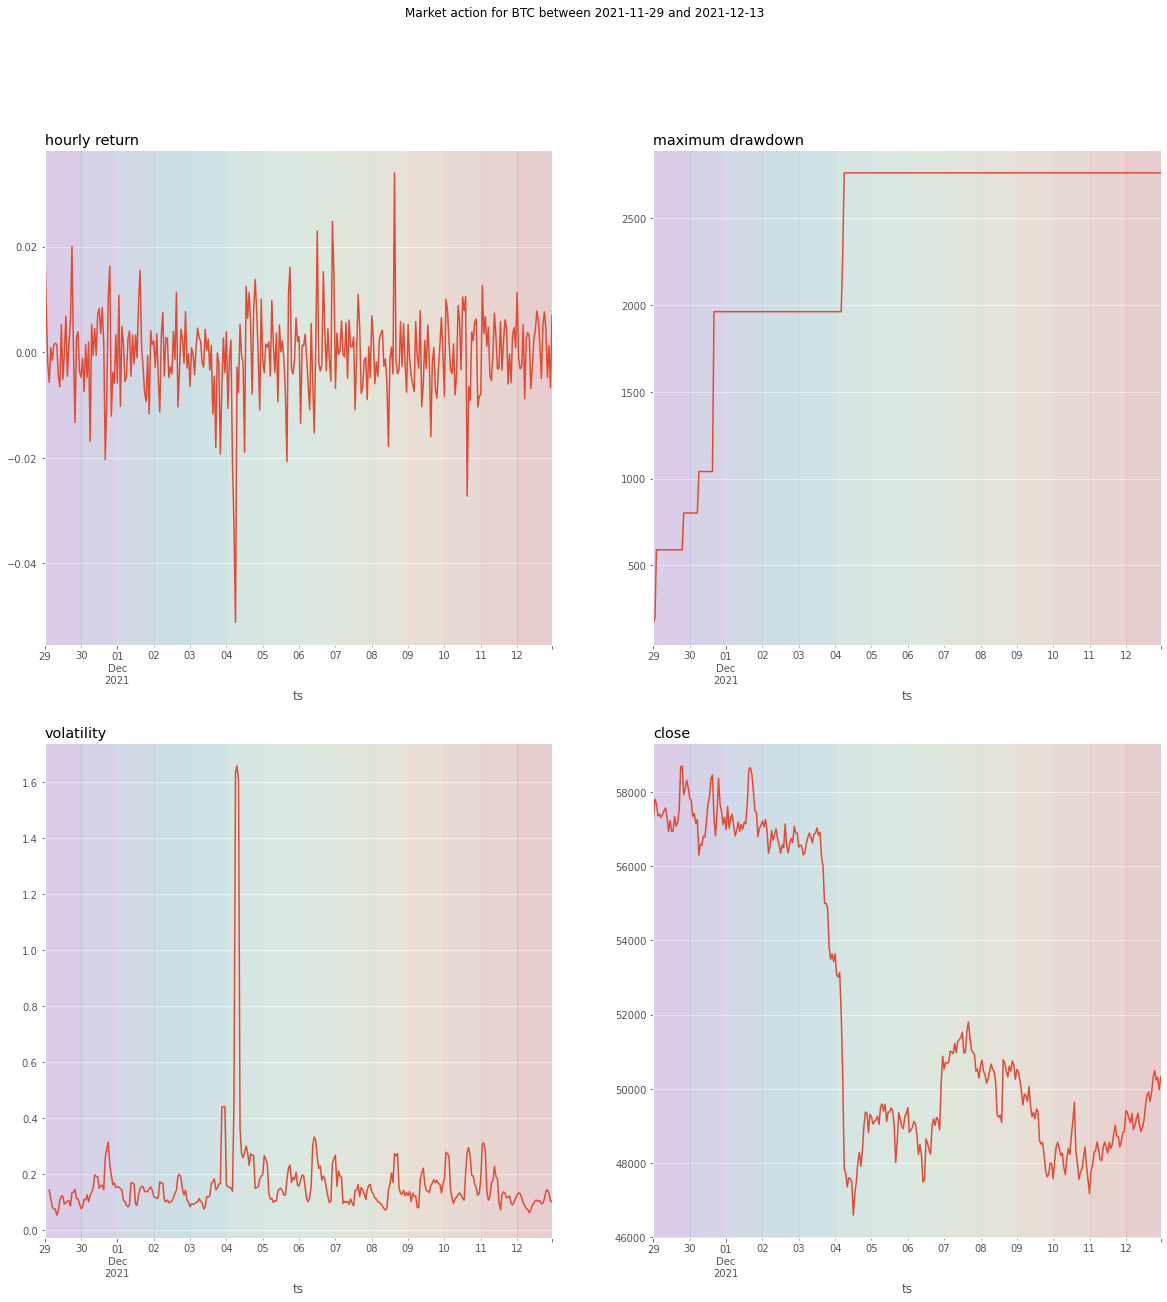

In [15]:
series_plot(prices[['hourly return']], ax=ax[0,0])
series_plot(prices[['volatility']], ax=ax[1,0])
series_plot(prices[['maximum drawdown']], ax=ax[0,1])
series_plot(prices[['close']], ax=ax[1,1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

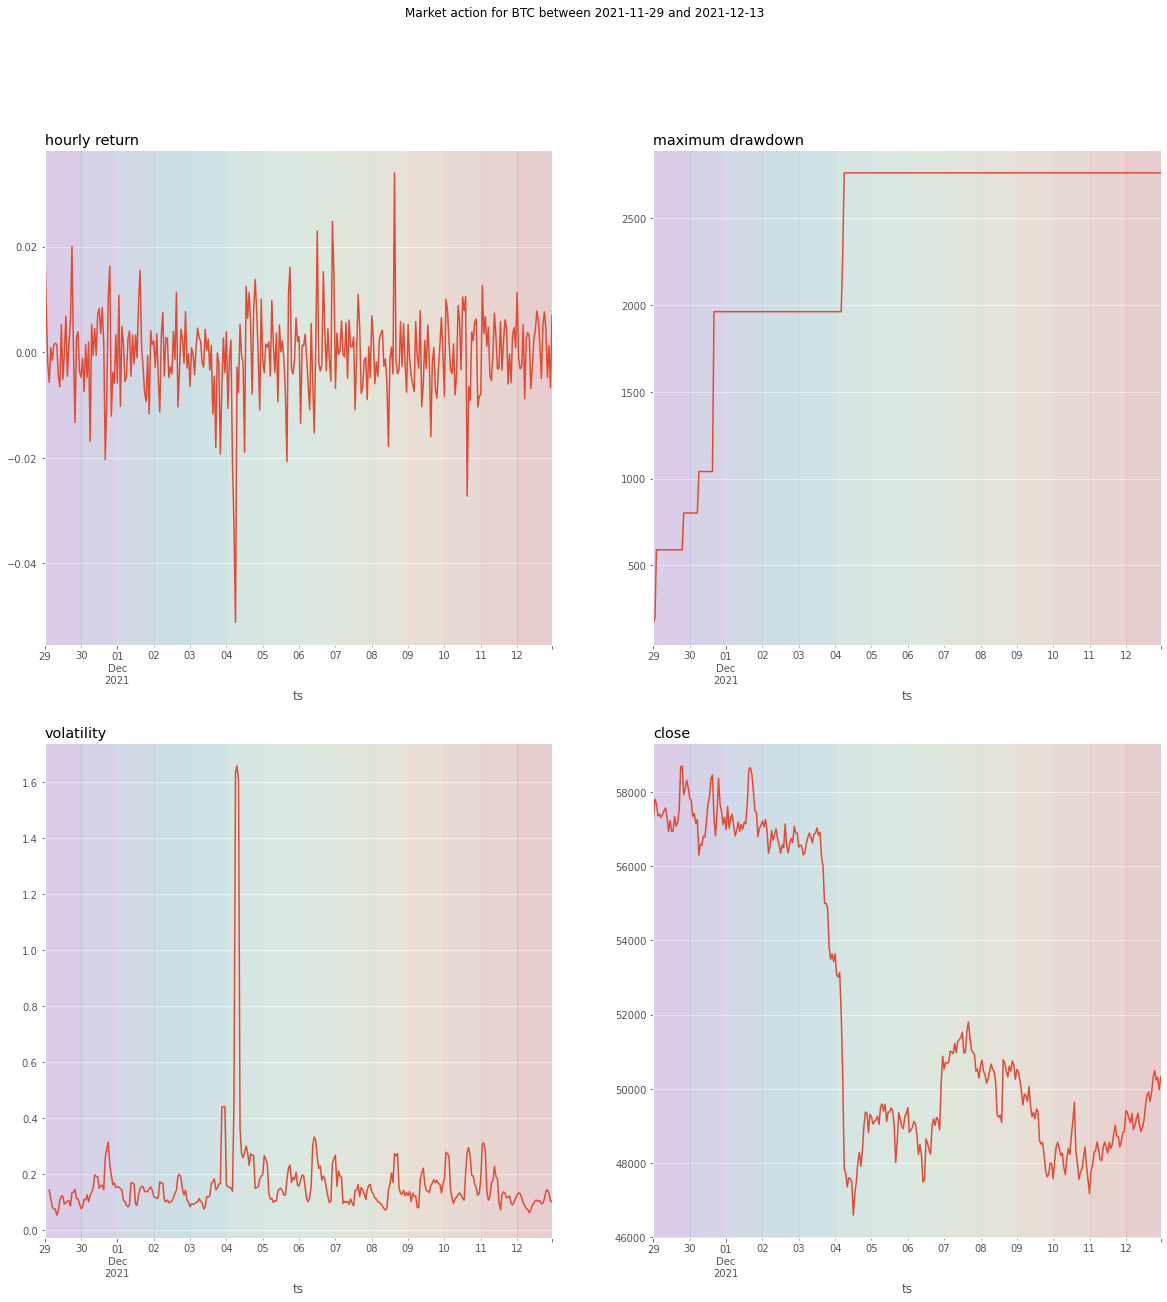

In [16]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)